# 🚀 Commodity Price Forecasting — Transformer Models Demo v2

This notebook demonstrates:
1. **Training** all 5 lightweight Transformers: PatchTST, DLinear, Autoformer, iTransformer, TSTransformer
2. **Fine-tuning** each model with `TransformerFineTuner`
3. **Visualization** — Predictions vs Ground Truth for every model
4. **Model Comparison** table & charts

In [6]:
import sys, os
sys.path.insert(0, os.path.abspath('.'))

import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from loguru import logger

print(f"PyTorch: {torch.__version__}")
print(f"CUDA: {torch.cuda.is_available()}")
print(f"Device: {torch.device('cuda' if torch.cuda.is_available() else 'cpu')}")

PyTorch: 2.4.1+cpu
CUDA: False
Device: cpu


## 1. Load & Prepare Data

In [7]:
from src.ingestion.loader import CommodityLoader
from src.preprocessing.cleaner import DataCleaner
from src.features.generator import FeatureGenerator

# Load data
loader = CommodityLoader('configs/commodities.yaml')
commodity_id = list(loader.commodities.keys())[9] if loader.commodities else 'steel_rebar'
print(f"Using: {commodity_id}")

df = loader.load_commodity(commodity_id)
df = DataCleaner().clean(df)
fg = FeatureGenerator(lag_days=[1,2,3,5,7,14,21,30], rolling_windows=[7,14,30,60])
df = fg.generate(df)

# Only numeric columns as features
exclude_cols = {'date', 'close', 'open', 'high', 'low', 'volume', 'commodity', 'commodity_id'}
feature_cols = [c for c in df.select_dtypes(include=[np.number]).columns if c not in exclude_cols]
df_clean = df.dropna(subset=feature_cols + ['close']).copy()

# Split 80/20
SEQ_LEN = 60
split = int(len(df_clean) * 0.8)
train_df = df_clean.iloc[:split]
test_df = df_clean.iloc[split:]
X_train, y_train = train_df[feature_cols], train_df['close']
X_test, y_test = test_df[feature_cols], test_df['close']

# Aligned ground truth: predict() returns (len - seq_len + 1) values
# so we align y_test to the LAST (len - seq_len + 1) values
n_preds = len(X_test) - SEQ_LEN + 1
y_test_aligned = y_test.iloc[SEQ_LEN - 1:].values  # shape = (n_preds,)

print(f"Features: {len(feature_cols)}, Train: {len(X_train)}, Test: {len(X_test)}")
print(f"Aligned predictions will have {n_preds} values")

2026-02-12 10:41:37.759 | INFO     | src.ingestion.loader:load_commodity:80 - Loaded 1489 records for rubber
2026-02-12 10:41:37.764 | INFO     | src.preprocessing.cleaner:_detect_frequency:114 - Auto-detected business frequency (0.0% weekend dates)


Using: rubber
Features: 55, Train: 1248, Test: 312
Aligned predictions will have 253 values


## 2. Train All Lightweight Models

In [8]:
from src.models.transformer_models import (
    PatchTSTForecaster, DLinearForecaster, AutoformerForecaster,
    iTransformerForecaster, TSTransformerForecaster
)
from src.evaluation.metrics import calculate_metrics

# Define models
model_configs = {
    'PatchTST': PatchTSTForecaster(seq_len=SEQ_LEN, epochs=50, lr=1e-3),
    'DLinear': DLinearForecaster(seq_len=SEQ_LEN, epochs=50, lr=1e-3),
    'Autoformer': AutoformerForecaster(seq_len=SEQ_LEN, epochs=50, lr=1e-3),
    'iTransformer': iTransformerForecaster(seq_len=SEQ_LEN, epochs=50, lr=1e-3),
    'TSTransformer': TSTransformerForecaster(seq_len=SEQ_LEN, epochs=50, lr=1e-3),
}

results = {}      # {name: metrics_dict}
predictions = {}  # {name: np.array of predictions}
trained_models = {}  # {name: fitted model}

for name, model in model_configs.items():
    print(f"\n{'='*60}")
    print(f"Training {name}...")
    try:
        model.fit(y_train, X_train, X_val=X_test, y_val=y_test)
        preds = model.predict(X=X_test)
        
        # Align: preds has shape (len(X_test) - seq_len + 1,)
        min_len = min(len(preds), len(y_test_aligned))
        preds_aligned = preds[:min_len]
        gt_aligned = y_test_aligned[:min_len]
        
        metrics = calculate_metrics(gt_aligned, preds_aligned, y_train.values)
        results[name] = metrics
        predictions[name] = preds_aligned
        trained_models[name] = model
        print(f"  ✅ MAE={metrics.get('mae',0):.4f}, RMSE={metrics.get('rmse',0):.4f}")
    except Exception as e:
        print(f"  ❌ ERROR: {e}")
        results[name] = {'error': str(e)}

print(f"\n{'='*60}")
print(f"Successfully trained: {list(predictions.keys())}")


Training PatchTST...


2026-02-12 10:41:41.171 | INFO     | src.models.transformer_models:fit:373 - Training PatchTST: 126,913 params, device=cpu, epochs=50
2026-02-12 10:41:41.662 | INFO     | src.models.transformer_models:fit:426 -   Epoch 1/50: train_loss=56537.094595, val_loss=84973.284180
2026-02-12 10:41:45.433 | INFO     | src.models.transformer_models:fit:426 -   Epoch 10/50: train_loss=717.537848, val_loss=792.431782
2026-02-12 10:41:49.578 | INFO     | src.models.transformer_models:fit:426 -   Epoch 20/50: train_loss=607.869443, val_loss=1229.950544
2026-02-12 10:41:53.944 | INFO     | src.models.transformer_models:fit:426 -   Epoch 30/50: train_loss=475.054775, val_loss=764.018841
2026-02-12 10:41:58.456 | INFO     | src.models.transformer_models:fit:426 -   Epoch 40/50: train_loss=466.294776, val_loss=883.071462
2026-02-12 10:42:02.555 | INFO     | src.models.transformer_models:fit:426 -   Epoch 50/50: train_loss=438.528141, val_loss=860.921271
2026-02-12 10:42:02.557 | INFO     | src.models.tran

  ✅ MAE=15.7767, RMSE=18.7715

Training DLinear...


2026-02-12 10:42:03.450 | INFO     | src.models.transformer_models:fit:426 -   Epoch 10/50: train_loss=1469.855255, val_loss=807.990440
2026-02-12 10:42:04.045 | INFO     | src.models.transformer_models:fit:426 -   Epoch 20/50: train_loss=3068.126686, val_loss=680.576466
2026-02-12 10:42:04.641 | INFO     | src.models.transformer_models:fit:426 -   Epoch 30/50: train_loss=269.854730, val_loss=407.143763
2026-02-12 10:42:05.239 | INFO     | src.models.transformer_models:fit:426 -   Epoch 40/50: train_loss=119.835459, val_loss=101.241210
2026-02-12 10:42:05.841 | INFO     | src.models.transformer_models:fit:426 -   Epoch 50/50: train_loss=35.724075, val_loss=85.501583
2026-02-12 10:42:05.843 | INFO     | src.models.transformer_models:fit:442 - DLinear training complete. Best val_loss=85.299816
2026-02-12 10:42:05.885 | INFO     | src.models.transformer_models:fit:373 - Training Autoformer: 72,641 params, device=cpu, epochs=50


  ✅ MAE=5.6941, RMSE=8.0137

Training Autoformer...


2026-02-12 10:42:07.121 | INFO     | src.models.transformer_models:fit:426 -   Epoch 1/50: train_loss=62101.319362, val_loss=102377.296875
2026-02-12 10:42:17.849 | INFO     | src.models.transformer_models:fit:426 -   Epoch 10/50: train_loss=3088.571946, val_loss=5625.039917
2026-02-12 10:42:29.712 | INFO     | src.models.transformer_models:fit:426 -   Epoch 20/50: train_loss=1636.997112, val_loss=279.171009
2026-02-12 10:42:42.221 | INFO     | src.models.transformer_models:fit:426 -   Epoch 30/50: train_loss=957.981503, val_loss=643.667816
2026-02-12 10:42:59.541 | INFO     | src.models.transformer_models:fit:426 -   Epoch 40/50: train_loss=730.741005, val_loss=421.581408
2026-02-12 10:43:14.450 | INFO     | src.models.transformer_models:fit:426 -   Epoch 50/50: train_loss=774.360380, val_loss=229.331753
2026-02-12 10:43:14.452 | INFO     | src.models.transformer_models:fit:442 - Autoformer training complete. Best val_loss=131.826858
2026-02-12 10:43:15.241 | INFO     | src.models.tra

  ✅ MAE=7.1913, RMSE=10.4611

Training iTransformer...


2026-02-12 10:43:16.223 | INFO     | src.models.transformer_models:fit:426 -   Epoch 1/50: train_loss=24921.491818, val_loss=3671.515991
2026-02-12 10:43:25.095 | INFO     | src.models.transformer_models:fit:426 -   Epoch 10/50: train_loss=661.371201, val_loss=7054.368500
2026-02-12 10:43:34.940 | INFO     | src.models.transformer_models:fit:426 -   Epoch 20/50: train_loss=579.211036, val_loss=3790.892101
2026-02-12 10:43:44.935 | INFO     | src.models.transformer_models:fit:426 -   Epoch 30/50: train_loss=468.821423, val_loss=3631.428207
2026-02-12 10:43:54.725 | INFO     | src.models.transformer_models:fit:426 -   Epoch 40/50: train_loss=420.273101, val_loss=5631.438950
2026-02-12 10:44:04.715 | INFO     | src.models.transformer_models:fit:426 -   Epoch 50/50: train_loss=414.984735, val_loss=5907.711853
2026-02-12 10:44:04.717 | INFO     | src.models.transformer_models:fit:442 - iTransformer training complete. Best val_loss=444.107391
2026-02-12 10:44:05.155 | INFO     | src.models.t

  ✅ MAE=17.8120, RMSE=21.1494

Training TSTransformer...


2026-02-12 10:44:06.096 | INFO     | src.models.transformer_models:fit:426 -   Epoch 1/50: train_loss=61437.112648, val_loss=100488.556641
2026-02-12 10:44:14.154 | INFO     | src.models.transformer_models:fit:426 -   Epoch 10/50: train_loss=2566.856628, val_loss=3643.084824
2026-02-12 10:44:22.872 | INFO     | src.models.transformer_models:fit:426 -   Epoch 20/50: train_loss=577.504802, val_loss=427.553766
2026-02-12 10:44:31.419 | INFO     | src.models.transformer_models:fit:426 -   Epoch 30/50: train_loss=604.076691, val_loss=333.165121
2026-02-12 10:44:42.574 | INFO     | src.models.transformer_models:fit:426 -   Epoch 40/50: train_loss=488.300801, val_loss=431.885975
2026-02-12 10:44:55.097 | INFO     | src.models.transformer_models:fit:426 -   Epoch 50/50: train_loss=504.363922, val_loss=180.219957
2026-02-12 10:44:55.101 | INFO     | src.models.transformer_models:fit:442 - TSTransformer training complete. Best val_loss=97.166234


  ✅ MAE=5.1723, RMSE=8.5711

Successfully trained: ['PatchTST', 'DLinear', 'Autoformer', 'iTransformer', 'TSTransformer']


## 3. Visualize Predictions vs Ground Truth (Each Model)

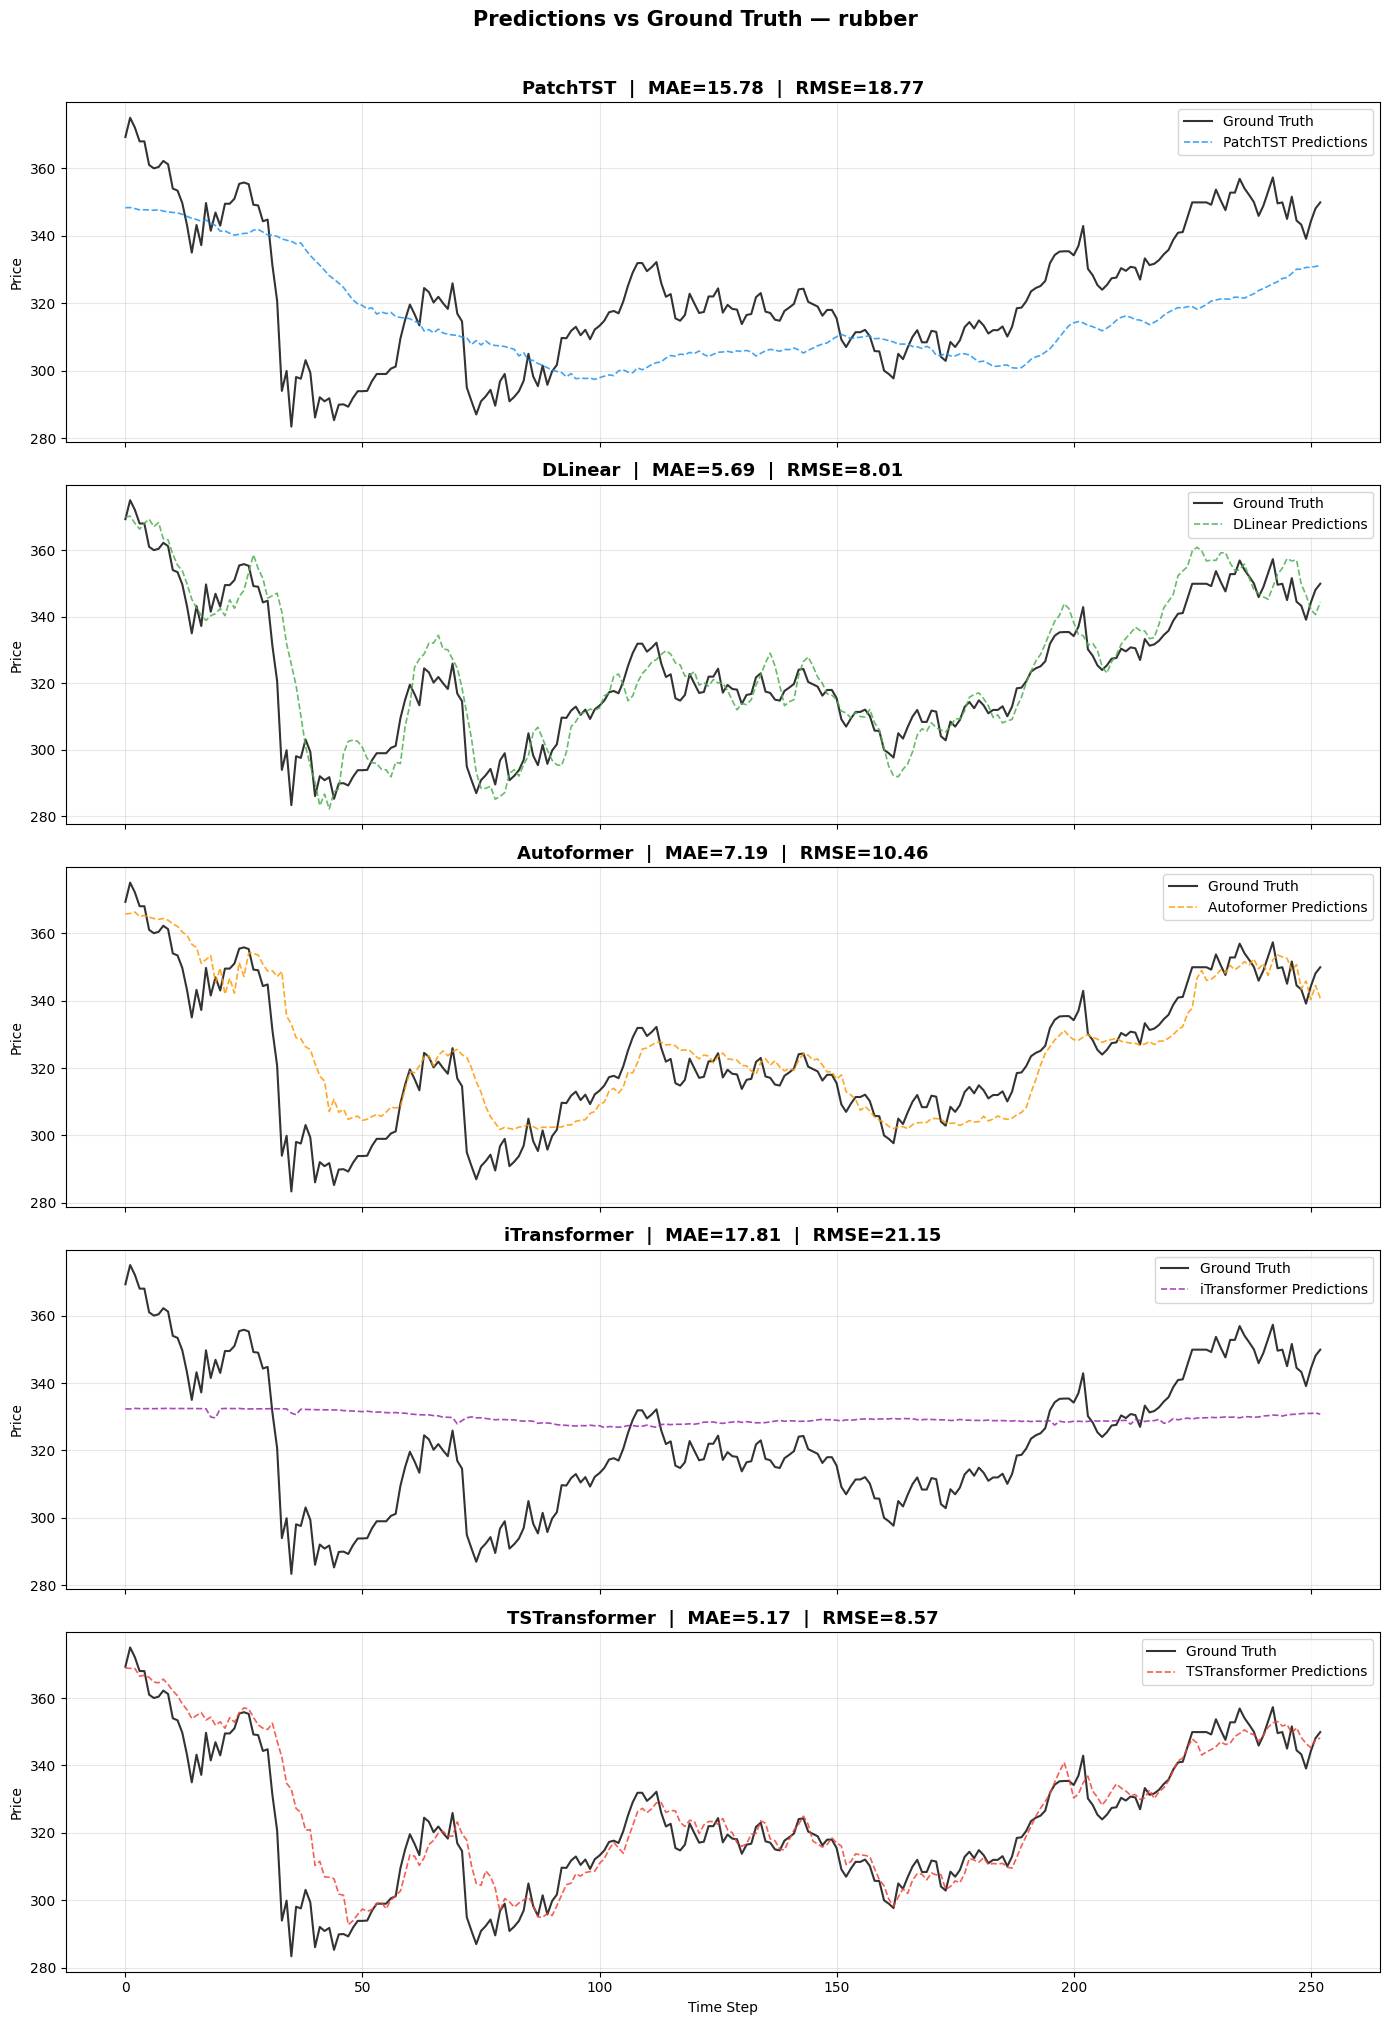

In [9]:
# Individual plots for each model
successful_models = [n for n in predictions.keys()]
n_models = len(successful_models)

if n_models > 0:
    fig, axes = plt.subplots(n_models, 1, figsize=(14, 4 * n_models), sharex=True)
    if n_models == 1:
        axes = [axes]
    
    colors = ['#2196F3', '#4CAF50', '#FF9800', '#9C27B0', '#F44336']
    
    for idx, name in enumerate(successful_models):
        ax = axes[idx]
        preds = predictions[name]
        gt = y_test_aligned[:len(preds)]
        
        ax.plot(gt, label='Ground Truth', color='black', linewidth=1.5, alpha=0.8)
        ax.plot(preds, label=f'{name} Predictions', color=colors[idx % len(colors)], 
                linewidth=1.2, alpha=0.85, linestyle='--')
        
        mae = results[name].get('mae', 0)
        rmse = results[name].get('rmse', 0)
        ax.set_title(f'{name}  |  MAE={mae:.2f}  |  RMSE={rmse:.2f}', fontsize=13, fontweight='bold')
        ax.legend(loc='upper right', fontsize=10)
        ax.grid(True, alpha=0.3)
        ax.set_ylabel('Price')
    
    axes[-1].set_xlabel('Time Step')
    plt.suptitle(f'Predictions vs Ground Truth — {commodity_id}', fontsize=15, fontweight='bold', y=1.01)
    plt.tight_layout()
    plt.show()
else:
    print("No models trained successfully.")

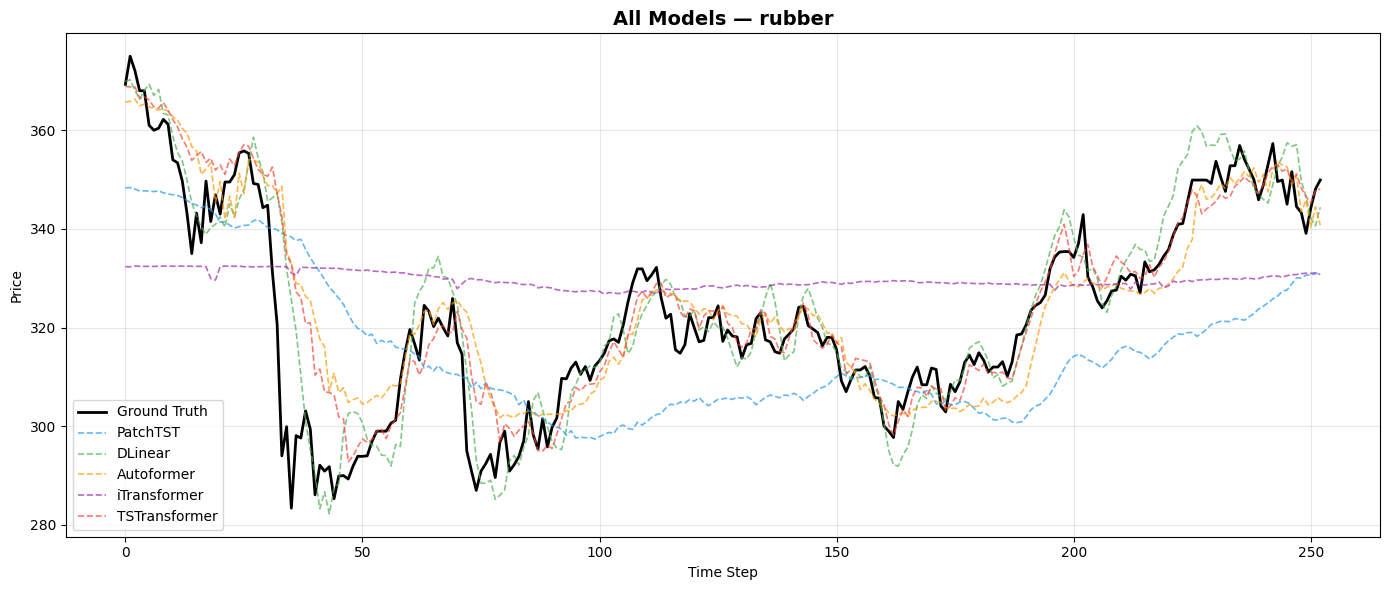

In [10]:
# Overlay plot: all models on one chart
if n_models > 0:
    fig, ax = plt.subplots(figsize=(14, 6))
    gt = y_test_aligned[:min(len(p) for p in predictions.values())]
    ax.plot(gt, label='Ground Truth', color='black', linewidth=2)
    
    for idx, (name, preds) in enumerate(predictions.items()):
        ax.plot(preds[:len(gt)], label=name, color=colors[idx % len(colors)], 
                linewidth=1.2, alpha=0.7, linestyle='--')
    
    ax.set_title(f'All Models — {commodity_id}', fontsize=14, fontweight='bold')
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)
    ax.set_xlabel('Time Step')
    ax.set_ylabel('Price')
    plt.tight_layout()
    plt.show()

## 4. Fine-tuning Each Model with TransformerFineTuner

In [11]:
from src.training.finetuner import TransformerFineTuner

ft_results = {}       # {name: finetune metrics}
ft_predictions = {}   # {name: predictions after fine-tuning}

for name, model in trained_models.items():
    print(f"\n{'='*60}")
    print(f"Fine-tuning {name}...")
    try:
        finetuner = TransformerFineTuner(
            model=model,
            seq_len=SEQ_LEN,
            lr=5e-5,          # Lower LR for fine-tuning
            epochs=50,
            patience=5,
            warmup_steps=50,
            grad_accum_steps=2,
            use_amp=torch.cuda.is_available(),
        )
        
        train_loader, val_loader = finetuner.prepare_data(
            df_clean, feature_cols, target_col='close', train_ratio=0.8
        )
        
        ft_metric = finetuner.finetune(train_loader, val_loader)
        ft_results[name] = ft_metric
        
        # Re-predict after fine-tuning
        preds_ft = model.predict(X=X_test)
        min_len = min(len(preds_ft), len(y_test_aligned))
        ft_predictions[name] = preds_ft[:min_len]
        
        eval_metrics = finetuner.evaluate(val_loader)
        print(f"  ✅ Fine-tune val_loss={ft_metric.get('best_val_loss',0):.6f}")
        print(f"     Eval: MSE={eval_metrics.get('mse',0):.4f}, MAE={eval_metrics.get('mae',0):.4f}")
    except Exception as e:
        print(f"  ❌ Fine-tuning failed: {e}")

2026-02-12 10:45:28.064 | INFO     | src.features.sequence_dataset:create_sequence_dataloaders:114 - Sequence dataset: train=1248, val=312, seq_len=60, horizon=1
2026-02-12 10:45:28.069 | INFO     | src.training.finetuner:prepare_data:121 - Fine-tuner data: 1188 train, 252 val samples
d:\Work\Comodity-Price-Forecasting\src\training\finetuner.py:181: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=self.use_amp)
2026-02-12 10:45:28.071 | INFO     | src.training.finetuner:finetune:187 - Fine-tuning PatchTST: params=126,913, device=cpu, epochs=50, AMP=False, grad_accum=2



Fine-tuning PatchTST...


d:\Work\Comodity-Price-Forecasting\src\training\finetuner.py:205: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=self.use_amp):
d:\Work\Comodity-Price-Forecasting\src\training\finetuner.py:296: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=self.use_amp):
2026-02-12 10:45:28.471 | INFO     | src.training.finetuner:finetune:243 -   Epoch 1/50: train=627.428112, val=317.527753, lr=1.80e-05
2026-02-12 10:45:30.270 | INFO     | src.training.finetuner:finetune:243 -   Epoch 5/50: train=487.466986, val=554.794662, lr=4.97e-05
2026-02-12 10:45:30.706 | INFO     | src.training.finetuner:finetune:250 -   Early stopping at epoch 6
2026-02-12 10:45:30.707 | INFO     | src.training.finetuner:finetune:273 - Fine-tuning complete. Best val_loss=317.527753 after 6 epochs.
2026-02-12 10:45:31.044 | INFO   

  ✅ Fine-tune val_loss=317.527753
     Eval: MSE=316.2867, MAE=13.5201

Fine-tuning DLinear...


2026-02-12 10:45:31.363 | INFO     | src.training.finetuner:finetune:243 -   Epoch 5/50: train=37.584965, val=93.043980, lr=4.97e-05
2026-02-12 10:45:31.682 | INFO     | src.training.finetuner:finetune:243 -   Epoch 10/50: train=49.940363, val=172.106791, lr=4.73e-05
2026-02-12 10:45:31.806 | INFO     | src.training.finetuner:finetune:250 -   Early stopping at epoch 12
2026-02-12 10:45:31.806 | INFO     | src.training.finetuner:finetune:273 - Fine-tuning complete. Best val_loss=82.679158 after 12 epochs.
2026-02-12 10:45:31.853 | INFO     | src.training.finetuner:evaluate:338 - Evaluation: MSE=83.140236, RMSE=9.118127, MAE=6.497797
2026-02-12 10:45:31.853 | INFO     | src.features.sequence_dataset:create_sequence_dataloaders:114 - Sequence dataset: train=1248, val=312, seq_len=60, horizon=1
2026-02-12 10:45:31.853 | INFO     | src.training.finetuner:prepare_data:121 - Fine-tuner data: 1188 train, 252 val samples
d:\Work\Comodity-Price-Forecasting\src\training\finetuner.py:181: FutureWa

  ✅ Fine-tune val_loss=82.679158
     Eval: MSE=83.1402, MAE=6.4978

Fine-tuning Autoformer...


d:\Work\Comodity-Price-Forecasting\src\training\finetuner.py:296: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=self.use_amp):
2026-02-12 10:45:33.061 | INFO     | src.training.finetuner:finetune:243 -   Epoch 1/50: train=818.710338, val=156.366056, lr=1.80e-05
2026-02-12 10:45:38.081 | INFO     | src.training.finetuner:finetune:243 -   Epoch 5/50: train=714.023689, val=189.671301, lr=4.97e-05
2026-02-12 10:45:39.314 | INFO     | src.training.finetuner:finetune:250 -   Early stopping at epoch 6
2026-02-12 10:45:39.314 | INFO     | src.training.finetuner:finetune:273 - Fine-tuning complete. Best val_loss=156.366056 after 6 epochs.
2026-02-12 10:45:40.108 | INFO     | src.training.finetuner:evaluate:338 - Evaluation: MSE=158.189590, RMSE=12.577344, MAE=8.575025
2026-02-12 10:45:40.110 | INFO     | src.features.sequence_dataset:create_sequence_dataloaders:114 - Sequence dataset: train=1248

  ✅ Fine-tune val_loss=156.366056
     Eval: MSE=158.1896, MAE=8.5750

Fine-tuning iTransformer...


d:\Work\Comodity-Price-Forecasting\src\training\finetuner.py:296: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=self.use_amp):
2026-02-12 10:45:41.086 | INFO     | src.training.finetuner:finetune:243 -   Epoch 1/50: train=1403.351300, val=484.922053, lr=1.80e-05
2026-02-12 10:45:44.952 | INFO     | src.training.finetuner:finetune:243 -   Epoch 5/50: train=1064.933825, val=977.346169, lr=4.97e-05
2026-02-12 10:45:46.907 | INFO     | src.training.finetuner:finetune:250 -   Early stopping at epoch 7
2026-02-12 10:45:46.909 | INFO     | src.training.finetuner:finetune:273 - Fine-tuning complete. Best val_loss=464.205369 after 7 epochs.
2026-02-12 10:45:47.341 | INFO     | src.training.finetuner:evaluate:338 - Evaluation: MSE=466.630096, RMSE=21.601622, MAE=17.872063
2026-02-12 10:45:47.343 | INFO     | src.features.sequence_dataset:create_sequence_dataloaders:114 - Sequence dataset: train=1

  ✅ Fine-tune val_loss=464.205369
     Eval: MSE=466.6301, MAE=17.8721

Fine-tuning TSTransformer...


d:\Work\Comodity-Price-Forecasting\src\training\finetuner.py:296: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=self.use_amp):
2026-02-12 10:45:48.170 | INFO     | src.training.finetuner:finetune:243 -   Epoch 1/50: train=548.554871, val=109.781116, lr=1.80e-05
2026-02-12 10:45:51.791 | INFO     | src.training.finetuner:finetune:243 -   Epoch 5/50: train=510.758093, val=169.578757, lr=4.97e-05
2026-02-12 10:45:52.716 | INFO     | src.training.finetuner:finetune:250 -   Early stopping at epoch 6
2026-02-12 10:45:52.719 | INFO     | src.training.finetuner:finetune:273 - Fine-tuning complete. Best val_loss=109.781116 after 6 epochs.
2026-02-12 10:45:53.186 | INFO     | src.training.finetuner:evaluate:338 - Evaluation: MSE=111.153519, RMSE=10.542937, MAE=6.661291


  ✅ Fine-tune val_loss=109.781116
     Eval: MSE=111.1535, MAE=6.6613


## 5. Before vs After Fine-tuning Comparison

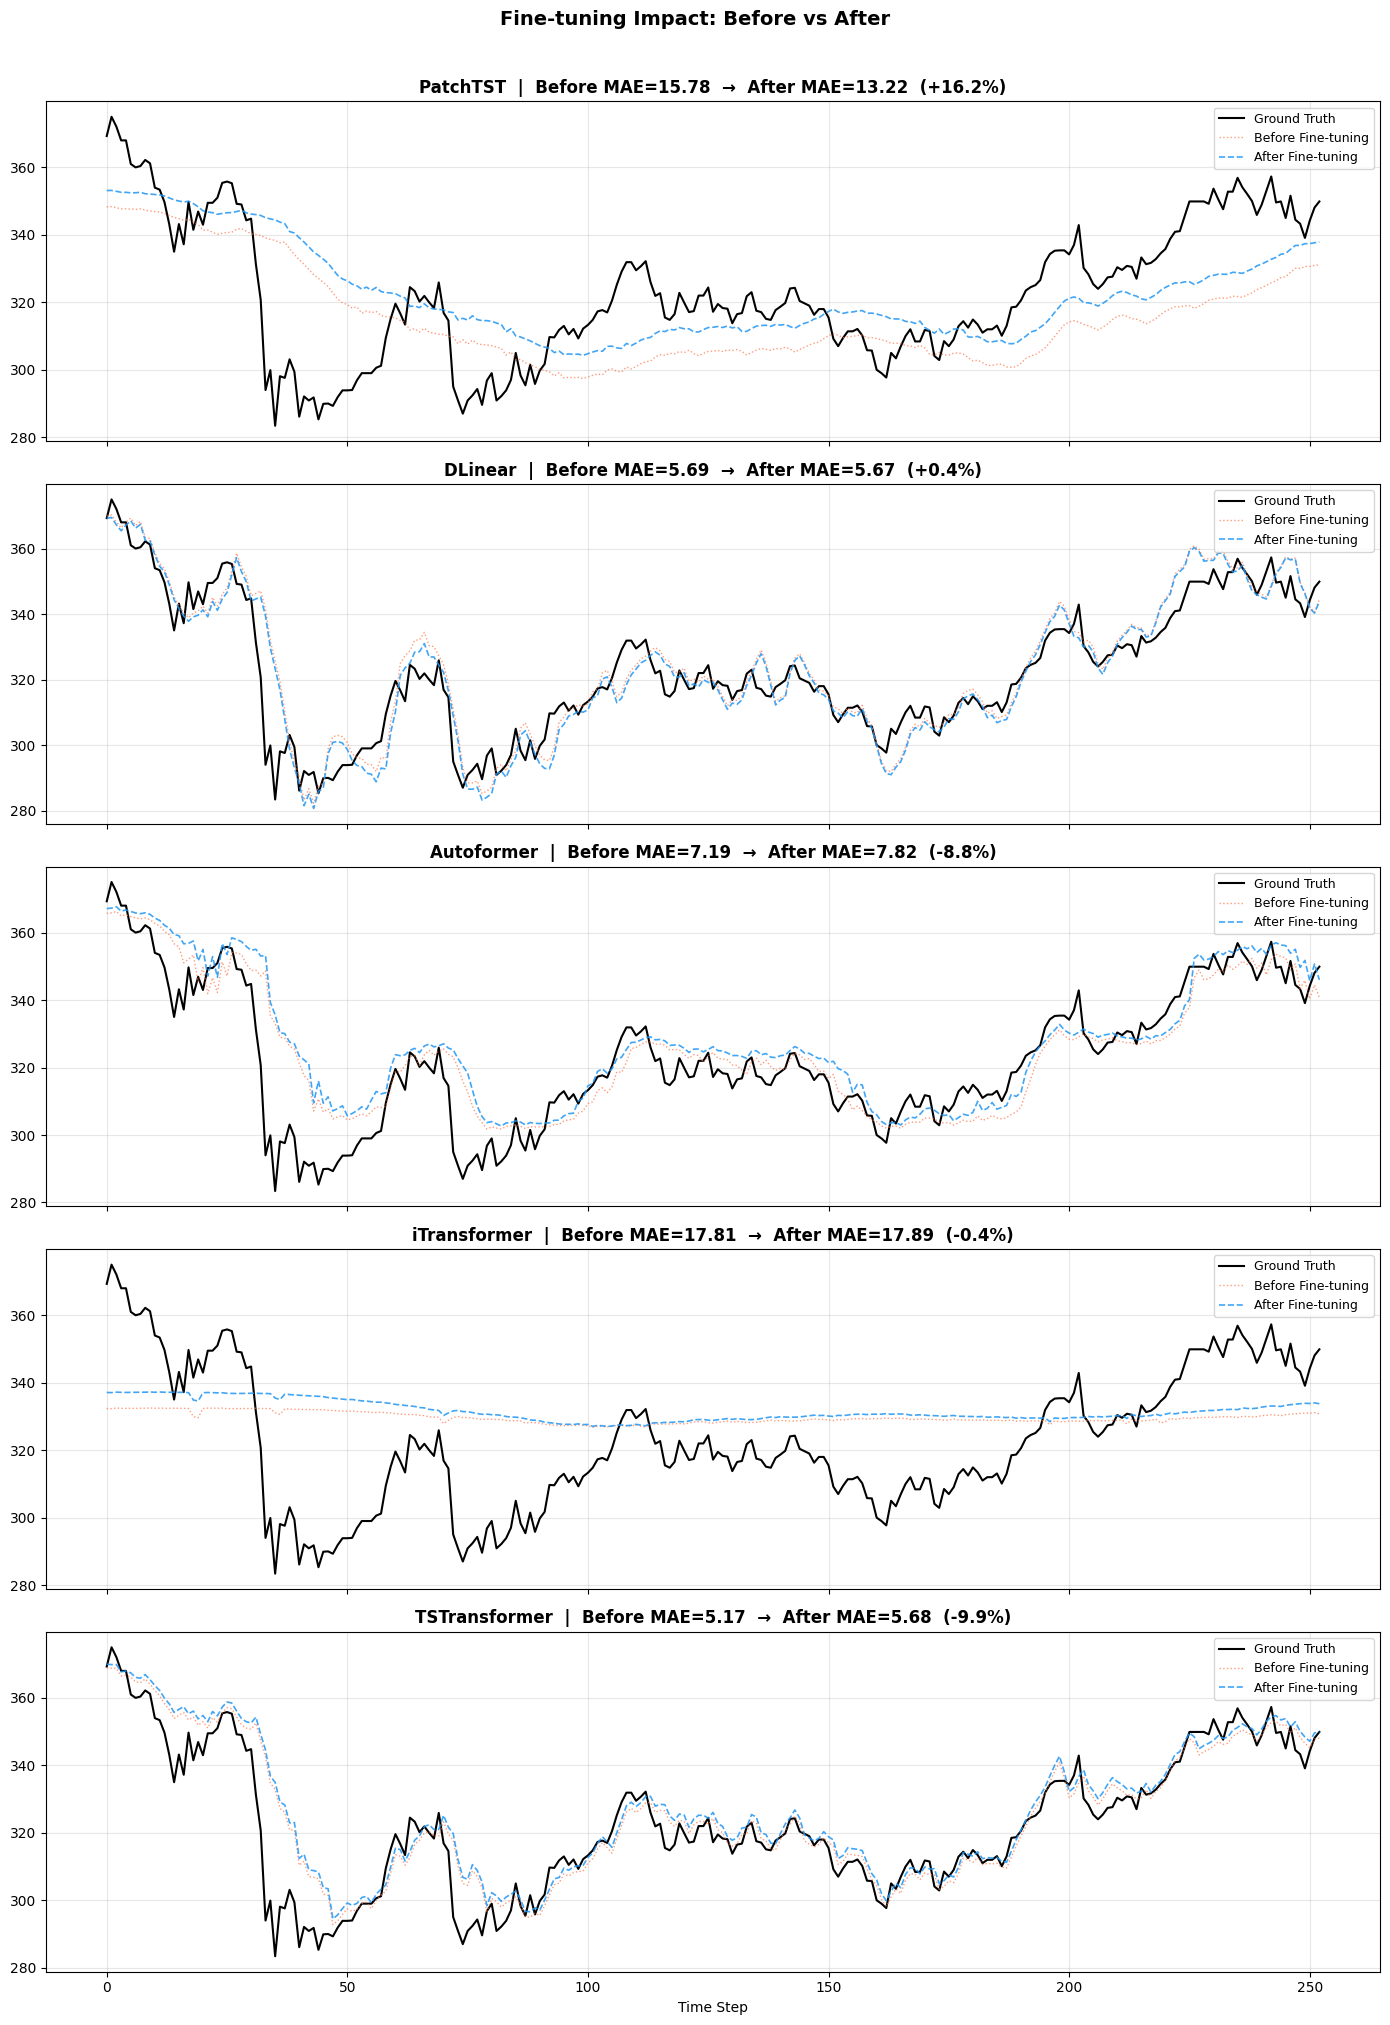

In [12]:
# Compare Before vs After fine-tuning for each model
models_with_ft = [n for n in ft_predictions.keys() if n in predictions]

if models_with_ft:
    fig, axes = plt.subplots(len(models_with_ft), 1, figsize=(14, 4 * len(models_with_ft)), sharex=True)
    if len(models_with_ft) == 1:
        axes = [axes]
    
    for idx, name in enumerate(models_with_ft):
        ax = axes[idx]
        preds_before = predictions[name]
        preds_after = ft_predictions[name]
        min_len = min(len(preds_before), len(preds_after), len(y_test_aligned))
        gt = y_test_aligned[:min_len]
        
        ax.plot(gt, label='Ground Truth', color='black', linewidth=1.5)
        ax.plot(preds_before[:min_len], label='Before Fine-tuning', 
                color='#FF7043', linewidth=1, alpha=0.7, linestyle=':')
        ax.plot(preds_after[:min_len], label='After Fine-tuning', 
                color='#2196F3', linewidth=1.2, alpha=0.85, linestyle='--')
        
        mae_before = np.mean(np.abs(gt - preds_before[:min_len]))
        mae_after = np.mean(np.abs(gt - preds_after[:min_len]))
        improvement = ((mae_before - mae_after) / mae_before * 100) if mae_before > 0 else 0
        
        ax.set_title(f'{name}  |  Before MAE={mae_before:.2f}  →  After MAE={mae_after:.2f}  '
                     f'({improvement:+.1f}%)', fontsize=12, fontweight='bold')
        ax.legend(loc='upper right', fontsize=9)
        ax.grid(True, alpha=0.3)
    
    axes[-1].set_xlabel('Time Step')
    plt.suptitle('Fine-tuning Impact: Before vs After', fontsize=14, fontweight='bold', y=1.01)
    plt.tight_layout()
    plt.show()
else:
    print("No fine-tuned models to compare.")

## 6. Model Comparison Table


📊 Model Comparison (sorted by MAE):
        Model     MAE    RMSE   MASE  sMAPE  MAE (Fine-tuned)
TSTransformer  5.1723  8.5711 1.7546 1.6164            5.6830
      DLinear  5.6941  8.0137 1.9316 1.7688            5.6739
   Autoformer  7.1913 10.4611 2.4395 2.2569            7.8207
     PatchTST 15.7767 18.7715 5.3519 4.9309           13.2249
 iTransformer 17.8120 21.1494 6.0423 5.5038           17.8870


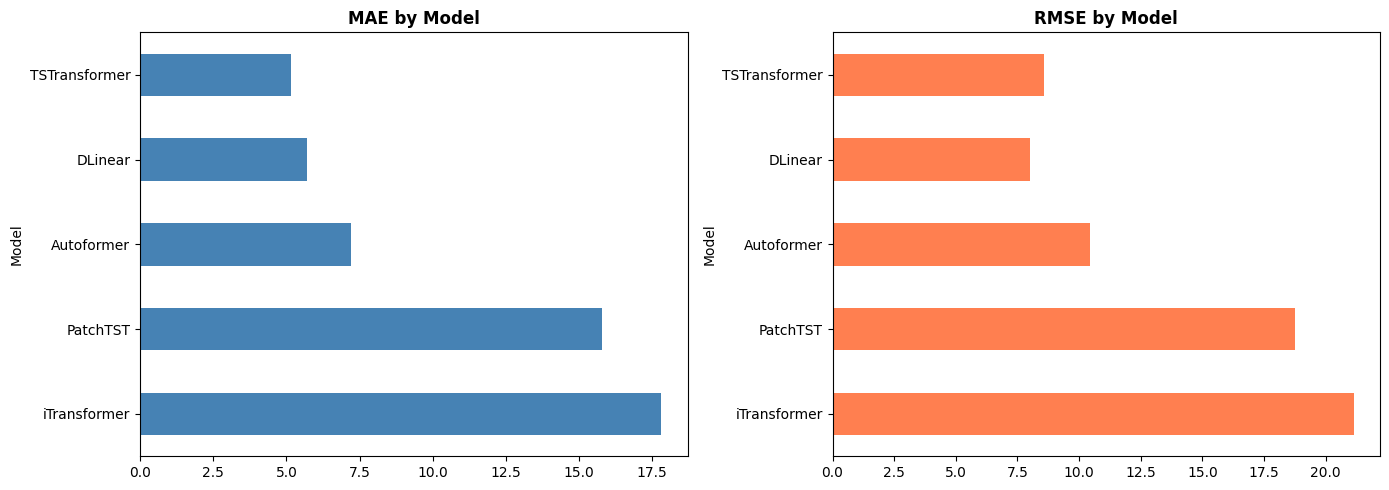

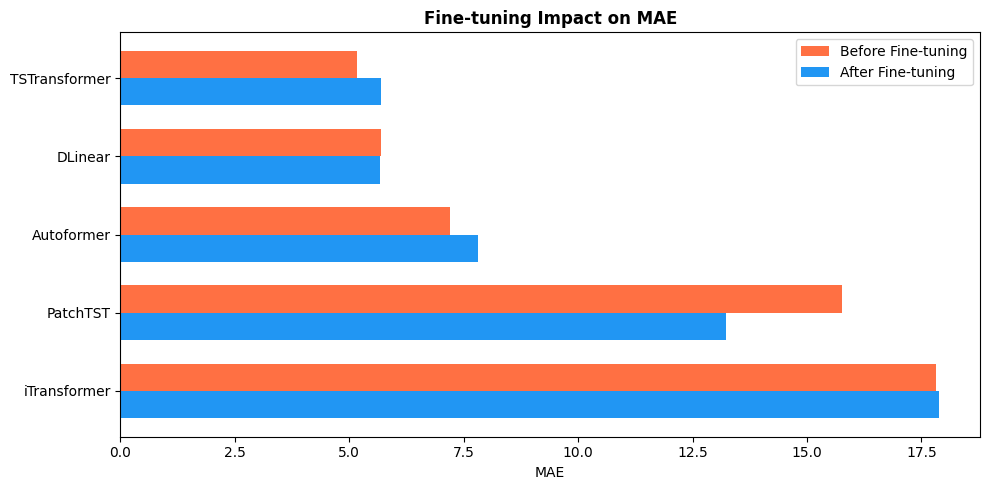

In [13]:
# Build comparison DataFrame
comparison = []
for name, metrics in results.items():
    if 'error' not in metrics:
        row = {
            'Model': name,
            'MAE': metrics.get('mae', None),
            'RMSE': metrics.get('rmse', None),
            'MASE': metrics.get('mase', None),
            'sMAPE': metrics.get('smape', None),
        }
        # Add fine-tuned MAE if available
        if name in ft_predictions:
            preds_ft = ft_predictions[name]
            gt = y_test_aligned[:len(preds_ft)]
            row['MAE (Fine-tuned)'] = np.mean(np.abs(gt - preds_ft))
        comparison.append(row)

if comparison:
    comp_df = pd.DataFrame(comparison)
    comp_df = comp_df.sort_values('MAE')
    print("\n📊 Model Comparison (sorted by MAE):")
    print(comp_df.to_string(index=False, float_format='%.4f'))
    
    # Bar chart
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    comp_df.plot.barh(x='Model', y='MAE', ax=axes[0], color='steelblue', legend=False)
    axes[0].set_title('MAE by Model', fontweight='bold')
    axes[0].invert_yaxis()
    
    comp_df.plot.barh(x='Model', y='RMSE', ax=axes[1], color='coral', legend=False)
    axes[1].set_title('RMSE by Model', fontweight='bold')
    axes[1].invert_yaxis()
    
    plt.tight_layout()
    plt.show()
    
    # Before vs After fine-tuning comparison
    if 'MAE (Fine-tuned)' in comp_df.columns:
        fig, ax = plt.subplots(figsize=(10, 5))
        x = range(len(comp_df))
        w = 0.35
        ax.barh([i - w/2 for i in x], comp_df['MAE'], w, label='Before Fine-tuning', color='#FF7043')
        ax.barh([i + w/2 for i in x], comp_df['MAE (Fine-tuned)'].fillna(comp_df['MAE']), w, 
                label='After Fine-tuning', color='#2196F3')
        ax.set_yticks(x)
        ax.set_yticklabels(comp_df['Model'])
        ax.set_xlabel('MAE')
        ax.set_title('Fine-tuning Impact on MAE', fontweight='bold')
        ax.legend()
        ax.invert_yaxis()
        plt.tight_layout()
        plt.show()
else:
    print("No successful model results to compare.")

## 7. Prediction Error Distribution

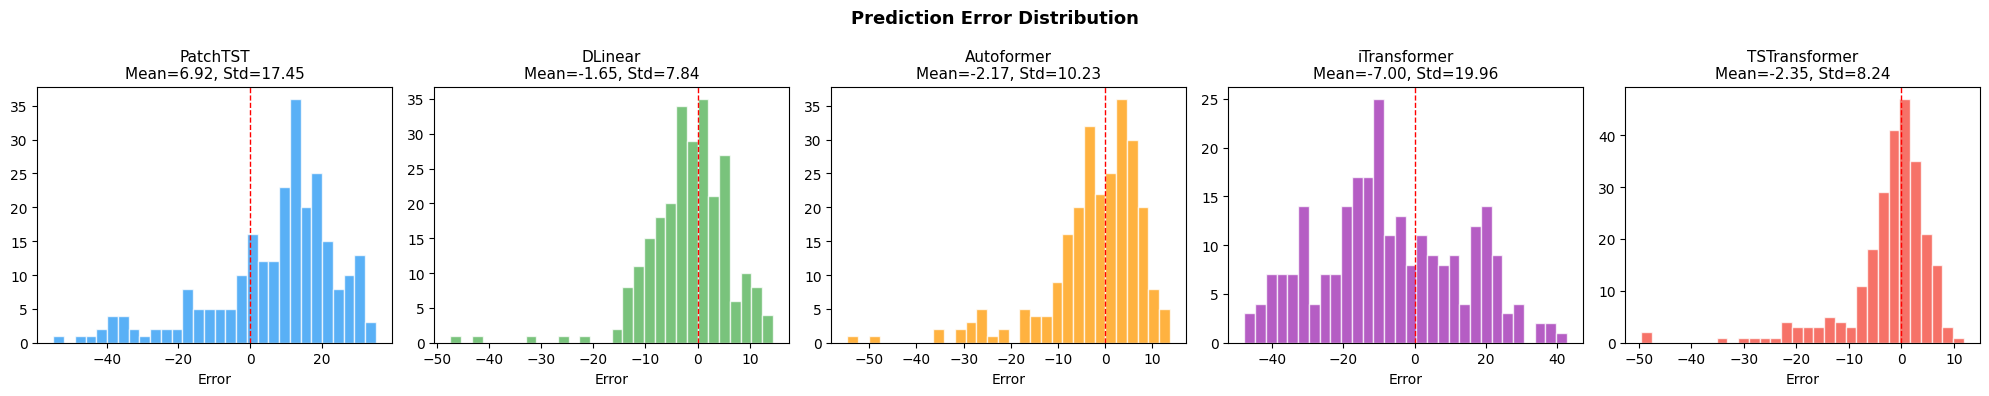

In [14]:
# Error distribution for each model
if predictions:
    fig, axes = plt.subplots(1, len(predictions), figsize=(4 * len(predictions), 4))
    if len(predictions) == 1:
        axes = [axes]
    
    for idx, (name, preds) in enumerate(predictions.items()):
        gt = y_test_aligned[:len(preds)]
        errors = gt - preds
        
        ax = axes[idx]
        ax.hist(errors, bins=30, color=colors[idx % len(colors)], alpha=0.75, edgecolor='white')
        ax.axvline(x=0, color='red', linestyle='--', linewidth=1)
        ax.set_title(f'{name}\nMean={np.mean(errors):.2f}, Std={np.std(errors):.2f}', fontsize=11)
        ax.set_xlabel('Error')
    
    plt.suptitle('Prediction Error Distribution', fontsize=13, fontweight='bold')
    plt.tight_layout()
    plt.show()

## 8. Future Price Prediction (Autoregressive)

Since our models are trained to predict t+1, we predict future prices step-by-step:

1. Predict t+1
2. Append prediction to history
3. Re-calculate features (lags, rolling stats, etc.)
4. Repeat for H steps

In [ ]:
def predict_future_autoregressive(model, start_df, horizon, feature_generator):
    """Predict future values autoregressively."""
    current_df = start_df.copy()
    future_preds = []

    static_cols = ["commodity_id", "commodity"]
    if not current_df.empty:
        last_row = current_df.iloc[-1]
        static_data = {c: last_row[c] for c in static_cols if c in current_df.columns}
        last_date = pd.to_datetime(current_df["date"].iloc[-1])
    else:
        raise ValueError("start_df is empty")

    future_dates = pd.bdate_range(start=last_date + pd.Timedelta(days=1), periods=horizon)
    print(f"Predicting {horizon} steps into the future...")
    target_col = feature_generator.target_column

    for i, date in enumerate(future_dates):
        row_data = {"date": [date]}
        for k, v in static_data.items():
            row_data[k] = [v]
        new_row = pd.DataFrame(row_data)

        current_df = pd.concat([current_df, new_row], ignore_index=True)

        try:
            current_df_feat = feature_generator.generate(current_df)
        except Exception as e:
            print(f"Feature generation warning at step {i}: {e}")
            current_df_feat = current_df

        if hasattr(model, "feature_names_") and getattr(model, "feature_names_", None):
            feats = list(model.feature_names_)
        else:
            exclude = {"date", target_col, "commodity", "commodity_id"}
            feats = [
                c for c in current_df_feat.columns
                if c not in exclude and pd.api.types.is_numeric_dtype(current_df_feat[c])
            ]

        try:
            valid_feats = [f for f in feats if f in current_df_feat.columns]
            if not valid_feats:
                raise ValueError("No valid features found")

            if hasattr(model, "seq_len"):
                seq_len = max(1, int(getattr(model, "seq_len", 1)))
                input_df = current_df_feat.tail(seq_len)[valid_feats]
            else:
                input_df = current_df_feat.tail(1)[valid_feats]

            input_df = input_df.ffill().fillna(0)
            pred_array = model.predict(horizon=1, X=input_df)

            arr = np.asarray(pred_array)
            if arr.size == 0:
                raise ValueError("Model returned empty prediction")
            pred_value = float(arr.reshape(-1)[-1])

        except Exception as e:
            print(f"Prediction failed at step {i} (model {type(model).__name__}): {e}")
            break

        current_df.loc[current_df.index[-1], target_col] = pred_value
        if "close" in current_df.columns and target_col != "close":
            current_df.loc[current_df.index[-1], "close"] = pred_value

        future_preds.append({"date": date, "pred": pred_value})

    return pd.DataFrame(future_preds, columns=["date", "pred"])

In [ ]:
if "trained_models" not in globals():
    print("Variable 'trained_models' is missing. Please run the training cell in Section 2 first.")
    trained_models = {}

if "df_clean" not in locals() or "fg" not in locals():
    raise ValueError("df_clean or fg is missing. Run the data preparation and feature engineering cells first.")

FUTURE_STEPS = 30
future_forecasts = {}

print(f"Generating future forecasts for {len(trained_models)} models...")
start_history = df_clean.tail(200).copy()

for name, model in trained_models.items():
    try:
        forecast_df = predict_future_autoregressive(
            model=model,
            start_df=start_history,
            horizon=FUTURE_STEPS,
            feature_generator=fg,
        )

        if forecast_df.empty or "pred" not in forecast_df.columns:
            print(f"  {name}: no forecast generated")
            continue

        future_forecasts[name] = forecast_df
        print(f"  {name}: {forecast_df['pred'].iloc[-1]:.2f}")

    except Exception as e:
        print(f"  {name} failed: {e}")

## 9. Visualize Future Predictions

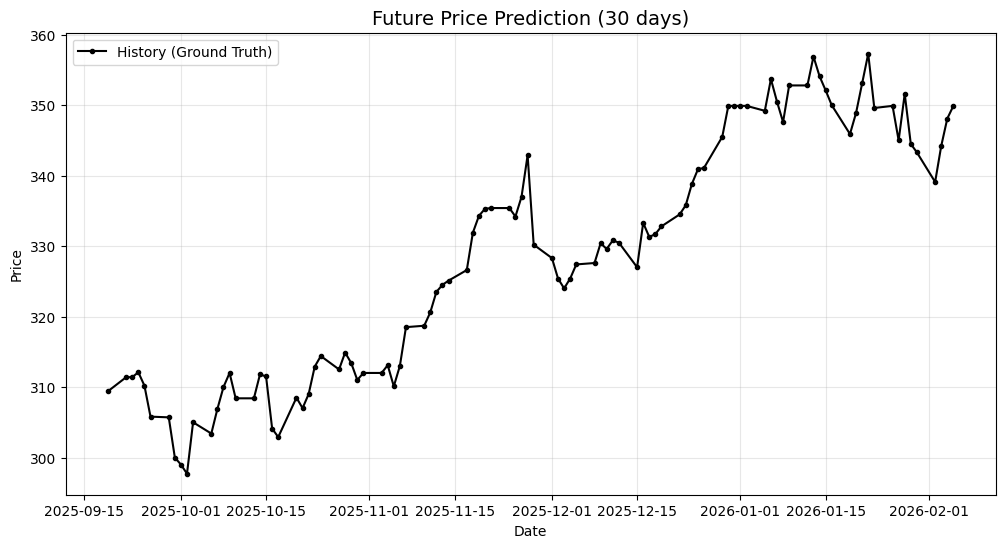

In [18]:
# Plot History + Future
plt.figure(figsize=(12, 6))

if 'df_clean' in locals() and not df_clean.empty:
    # Plot last N days of history
    history_window = 100
    history = df_clean.iloc[-history_window:]
    plt.plot(history['date'], history['close'], 'k.-', label='History (Ground Truth)', linewidth=1.5)

    for idx, (name, forecast_df) in enumerate(future_forecasts.items()):
        if not forecast_df.empty:
            # Connect last history point to first prediction
            last_inv_date = history['date'].iloc[-1]
            last_val = history['close'].iloc[-1]
            
            dates = [last_inv_date] + list(forecast_df['date'])
            values = [last_val] + list(forecast_df['pred'])
            
            # Use color cycle if possible
            if 'colors' in locals():
                 color = colors[idx % len(colors)]
            else:
                 color = None
                 
            plt.plot(dates, values, '.-', color=color, label=f'{name} Forecast')

    plt.title(f'Future Price Prediction ({FUTURE_STEPS} days)', fontsize=14)
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
else:
    print("No history data to plot.")

## Summary

| Category | Models | Training |
|----------|--------|----------|
| **Lightweight** | PatchTST, DLinear, Autoformer, iTransformer, TSTransformer | Train from scratch |
| **Fine-tuning** | TransformerFineTuner | AMP, gradient accum, warmup, early stopping |

### Key Takeaways
- **DLinear** is the simplest and fastest — excellent baseline
- **PatchTST** captures local patterns well with patch-based attention
- **Autoformer** excels with periodic/seasonal data
- **Fine-tuning** with lower LR can improve all models further